<a href="https://colab.research.google.com/github/rdmila/lab-python/blob/main/lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [1]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [2]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Физик-ядерщик",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [3]:
data.keys()

dict_keys(['items', 'found', 'pages', 'per_page', 'page', 'clusters', 'arguments', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [4]:
# Получим id города Москвы (Из документации hh: "Значения в справочниках могут
# поменяться в любой момент. Не нужно завязываться на них". То есть лучше 
# научиться получать id кодом, а не ручками переписывать номер).

BASE_URL = 'https://api.hh.ru/'
AREAS_URL = BASE_URL + 'areas/'
COUNTRIES_URL = AREAS_URL + 'countries/'

countries = requests.get(COUNTRIES_URL).json()
for c in countries:
  if c['name'] == "Россия":
    russia_id = c['id']
    break

RUSSIA_URL = AREAS_URL + russia_id + '/'
russia = requests.get(RUSSIA_URL).json()

for reg in russia['areas']:
  if reg['name'] == "Москва":
    moscow_id = reg['id']
    break

print(moscow_id)

1


In [5]:
# Чтобы не забыть вызывать sleep
def get(URL, params):
  sleep(0.1)
  return requests.get(URL, params)

In [6]:
from pandas._config import reset_option
VAC_URL = BASE_URL + 'vacancies/'

professions = ['C++ developer', 'Сетевой инженер', 'Data scientist', 
               'Тестировщик', 'Дизайнер']

params = {
  'text': '',
  'area': moscow_id,
  'per_page': 100
}

vacancies = dict()

for prof in professions:
  vacancies[prof] = []

  params['text'] = prof
  params['page'] = 0
  pages_cnt = 1

  while params['page'] < pages_cnt:
    resp = get(VAC_URL, params).json()
    pages_cnt = resp['pages']
    vacancies[prof] += resp['items']
    params['page'] = resp['page'] + 1


(1 балл) Посчитайте сколько всего найдено вакансий:

In [7]:
vac_cnts = [len(vacancies[prof]) for prof in professions]
overall_vac_cnt = sum(vac_cnts)
print(overall_vac_cnt)

5874


(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [8]:
class Company:
    def __init__(self, name, coords):
      self.name = name
      self.coords = coords

(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [9]:
def get_vac_coords(vac):
  address = vac.get('address')
  if address is None:
    return (None, None)
  return (address.get('lat'), address.get('lng'))


companies = set()
cnt = 0
for prof in vacancies:
  for vac in vacancies[prof]:
    employer_name = vac['employer']['name']
    coords = get_vac_coords(vac)
    companies.add(Company(employer_name, coords))
print(len(companies))
elem = next(iter(companies))
print(elem.name, elem.coords)

5874
Яндекс (55.699436, 37.462496)


(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [10]:
vacs_coords = []
for prof in vacancies:
  for vac in vacancies[prof]:
    coords = get_vac_coords(vac)
    if coords != (None, None):
      vacs_coords.append(coords)
print(len(vacs_coords))

3060


(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [11]:
MOSCOW_CENTER = (55.751531, 37.619510)
POINT_ON_MKAD = (55.886170, 37.620265)
moscow_radius_vec = np.subtract(POINT_ON_MKAD, MOSCOW_CENTER)
moscos_radius_len = np.linalg.norm(moscow_radius_vec)

in_mkad_vacs_coords = [coords for coords in vacs_coords if 
                       np.linalg.norm(np.subtract(coords, MOSCOW_CENTER)) <= moscos_radius_len]
print(len(in_mkad_vacs_coords))

2416


  (1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

In [12]:
# your code here

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве): 

In [13]:
# your code here

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

Ваши выводы здесь :)

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [14]:
!gdown 1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU

Downloading...
From: https://drive.google.com/uc?id=1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 120MB/s]


Создадим DataFrame:

In [15]:
diamonds = pd.read_csv("diamonds.csv")

(0.5 балла) Выведете первые 5 строк датасета:

In [16]:
diamonds.head(5)

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,None,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,None,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,None,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [17]:
len(diamonds.index)

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [18]:
cost_series = diamonds['total_sales_price']
print("Diamond number", cost_series.idxmax(), "has maximum cost of", cost_series.max())
print("Diamond number", cost_series.idxmin(), "has minumum cost of", cost_series.min())

Diamond number 219702 has maximum cost of 1449881
Diamond number 0 has minumum cost of 200


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [19]:
sum_skips = 0
skip_values = ["unknown", "None"]
for column in diamonds:
  skips = len(diamonds[diamonds[column].isin(skip_values)])
  sum_skips += skips
print(sum_skips)

1891168


(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [20]:
for column in diamonds:
  skips = len(diamonds[diamonds[column].isin(skip_values)])
  if skips > 0:
    print(column)

color
cut_quality
eye_clean
culet_size
culet_condition
girdle_min
girdle_max
fluor_color
fluor_intensity
fancy_color_dominant_color
fancy_color_secondary_color
fancy_color_overtone
fancy_color_intensity


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными. 

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [21]:
bad_columns = [col for col in diamonds if col.startswith("fancy_color_") or col.startswith("fluor_")]
print(len(bad_columns))
print(bad_columns)

6
['fluor_color', 'fluor_intensity', 'fancy_color_dominant_color', 'fancy_color_secondary_color', 'fancy_color_overtone', 'fancy_color_intensity']


2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках: 

In [22]:
for col in bad_columns:
  print(col, len(diamonds[~diamonds[col].isin(skip_values)]))

fluor_color 15726
fluor_intensity 76084
fancy_color_dominant_color 9164
fancy_color_secondary_color 1062
fancy_color_overtone 388
fancy_color_intensity 9162


3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [23]:
bad_columns = [col for col in diamonds if col.startswith("fancy_color_") or col.startswith("fluor_")]
diamonds.drop(bad_columns, axis=1, inplace=True)

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [24]:
culet_cols = [col for col in diamonds if col.startswith("culet_")]
diamonds.drop(culet_cols, axis=1, inplace=True)
diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.9,59.0,2.84,2.89,1.78,STK,STK,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.0,59.0,2.86,2.88,1.78,M,STK,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,64.8,65.0,11.55,8.81,5.71,TK,XTK,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,70.8,72.0,5.22,4.90,3.47,XTN,VTK,1350000


(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [25]:
sum(diamonds["total_sales_price"]) / 1000

1517721.991

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [26]:
diamonds.loc[0::2]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [27]:
diamonds.loc[0::6]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [28]:
print(diamonds.dtypes)
cat_diamonds = diamonds.select_dtypes(include='object')
cat_diamonds

Unnamed: 0             int64
cut                   object
color                 object
clarity               object
carat_weight         float64
cut_quality           object
lab                   object
symmetry              object
polish                object
eye_clean             object
depth_percent        float64
table_percent        float64
meas_length          float64
meas_width           float64
meas_depth           float64
girdle_min            object
girdle_max            object
total_sales_price      int64
dtype: object


,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,unknown,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,unknown,STK,STK
...,...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,M,STK
219699,Radiant,unknown,VS2,unknown,GIA,Very Good,Very Good,unknown,TK,XTK
219700,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,TN,M
219701,Princess,unknown,SI2,unknown,GIA,Good,Good,unknown,XTN,VTK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [29]:
costs = diamonds.head(10000)["total_sales_price"].to_frame()
costs_transposed = costs.T
costs.dot(costs_transposed)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,...,126000,126000,126000,126000,126000,126000,126000,126000,126000,126000
1,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,...,126000,126000,126000,126000,126000,126000,126000,126000,126000,126000
2,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,...,126000,126000,126000,126000,126000,126000,126000,126000,126000,126000
3,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,...,126000,126000,126000,126000,126000,126000,126000,126000,126000,126000
4,40000,40000,40000,40000,40000,40000,40000,40000,40000,40000,...,126000,126000,126000,126000,126000,126000,126000,126000,126000,126000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,126000,126000,126000,126000,126000,126000,126000,126000,126000,126000,...,396900,396900,396900,396900,396900,396900,396900,396900,396900,396900
9996,126000,126000,126000,126000,126000,126000,126000,126000,126000,126000,...,396900,396900,396900,396900,396900,396900,396900,396900,396900,396900
9997,126000,126000,126000,126000,126000,126000,126000,126000,126000,126000,...,396900,396900,396900,396900,396900,396900,396900,396900,396900,396900
9998,126000,126000,126000,126000,126000,126000,126000,126000,126000,126000,...,396900,396900,396900,396900,396900,396900,396900,396900,396900,396900


### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

In [30]:
# your code here

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

In [31]:
# your code here

(2 балла) Постройте график `вес бриллианта - стоимость`:

In [32]:
# your code here

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

In [33]:
# your code here

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

Ваши выводы здесь :)

## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно: 
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк: 

In [34]:
df = diamonds[["meas_length", "meas_width", "meas_depth", "total_sales_price"]]
df.head(10)

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
5,2.95,2.99,1.81,200
6,2.85,2.88,1.84,200
7,2.86,2.89,1.78,200
8,2.89,2.92,1.85,200
9,2.83,2.87,1.80,200


(1 балл) Перемешайте строки в датафрейме случайным образом: 

In [35]:
from sklearn.utils import shuffle
df = shuffle(df)
df

,meas_length,meas_width,meas_depth,total_sales_price
30696,4.25,4.28,2.68,792
204761,7.16,7.18,4.43,18710
23368,5.72,4.15,2.57,758
83840,4.17,4.06,2.95,1232
62570,5.29,3.81,2.40,990
...,...,...,...,...
43200,4.27,4.29,2.64,896
54206,4.27,4.29,2.66,952
93621,5.50,4.12,2.75,1442
122220,4.54,4.39,2.88,2472


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [36]:
df['minkovsky_metric'] = df.apply(lambda row: np.sum(np.array([row[i] for i in range(3)]) ** 3) ** (1/3), axis=1)
df

,meas_length,meas_width,meas_depth,total_sales_price,minkovsky_metric
30696,4.25,4.28,2.68,792,5.587229
204761,7.16,7.18,4.43,18710,9.375651
23368,5.72,4.15,2.57,758,6.507661
83840,4.17,4.06,2.95,1232,5.485997
62570,5.29,3.81,2.40,990,6.010779
...,...,...,...,...,...
43200,4.27,4.29,2.64,896,5.595658
54206,4.27,4.29,2.66,952,5.600140
93621,5.50,4.12,2.75,1442,6.358738
122220,4.54,4.39,2.88,2472,5.868133


(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`: 

In [37]:
form_and_price = df[['minkovsky_metric', 'total_sales_price']]
form_and_price

,minkovsky_metric,total_sales_price
30696,5.587229,792
204761,9.375651,18710
23368,6.507661,758
83840,5.485997,1232
62570,6.010779,990
...,...,...
43200,5.595658,896
54206,5.600140,952
93621,6.358738,1442
122220,5.868133,2472


(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [38]:
train, test = np.split(form_and_price, [int(0.8 * len(df))])
print(len(train), len(test))

175762 43941


(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

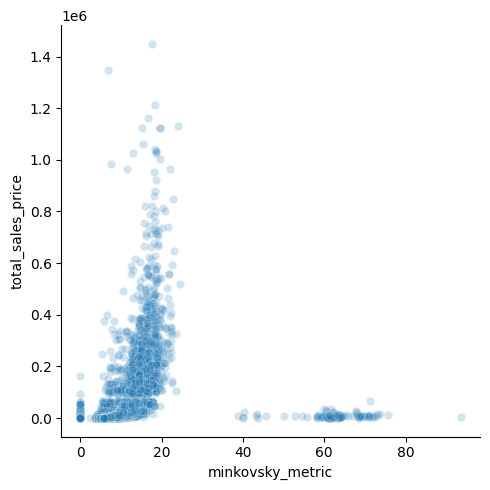

In [39]:
sns.relplot(
    data=train,
    x="minkovsky_metric", y="total_sales_price",
    alpha=0.2
)

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

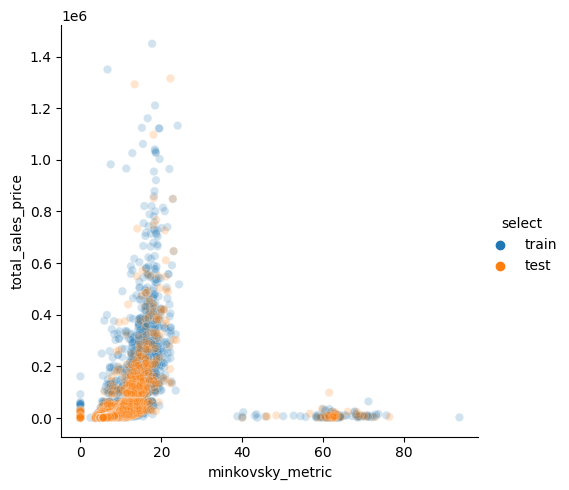

In [40]:
train = train.assign(select=lambda x: "train")
test = test.assign(select=lambda x: "test")
merged = pd.concat([train, test])
sns.relplot(
    data=merged,
    x="minkovsky_metric", y="total_sales_price",
    hue="select",
    alpha=0.2
)

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [57]:
def closest_id(value):
    idx = np.searchsorted(train['minkovsky_metric'].values, value)
    return idx - 1 if idx >= len(train) or value - train.iloc[idx - 1, 1] <= train.iloc[idx, 1] - value else idx
    
    
train.sort_values('minkovsky_metric')
test['neigbor_iloc'] = (test['minkovsky_metric']).apply(closest_id)
test

,minkovsky_metric,total_sales_price,select,neigbor_iloc,neighbor_dif_percents
33444,4.996706,812,test,-1,14.796749
2110,5.606016,430,test,23540,8.595541
143280,7.764622,3527,test,130432,25.809032
178366,9.343598,7560,test,131564,41.044437
89720,5.610549,1368,test,23540,8.669392
...,...,...,...,...,...
43200,5.595658,896,test,22056,7.888099
54206,5.600140,952,test,22056,7.961820
93621,6.358738,1442,test,51975,22.583005
122220,5.868133,2472,test,49638,5.305119


(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [58]:
def diff(row):
    in_test = row['minkovsky_metric']
    in_train = train.iloc[row['neigbor_iloc'], 0]
    return None if in_test == 0 else abs(in_test - in_train) / in_test * 100


test['neighbor_dif_percents'] = test.apply(diff, axis=1)
test

,minkovsky_metric,total_sales_price,select,neigbor_iloc,neighbor_dif_percents
33444,4.996706,812,test,-1,14.796749
2110,5.606016,430,test,23540,8.595541
143280,7.764622,3527,test,130432,25.809032
178366,9.343598,7560,test,131564,41.044437
89720,5.610549,1368,test,23540,8.669392
...,...,...,...,...,...
43200,5.595658,896,test,22056,7.888099
54206,5.600140,952,test,22056,7.961820
93621,6.358738,1442,test,51975,22.583005
122220,5.868133,2472,test,49638,5.305119


**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [43]:
# your code here

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [44]:
# your code here

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [45]:
# your code here

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [46]:
# your code here

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)